# Covid 19 Cases PredictionAssignment

### Tasks include:
#### 1. Develop an LSTM model to predict COVID cases in Malaysia.
#### 2. Ensure MAPE error is less than 1% on the testing dataset.
#### 3. Display training loss using TensorBoard.

In [1]:
# 1 Setup
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import IPython.display
import matplotlib as mpl
from tensorflow import keras
from  keras import callbacks
import matplotlib.pyplot as plt
from windowing import WindowGenerator

In [2]:
# 2 Load train data as Dataframe
df_cases_train_malaysia = pd.read_csv('2024_COVID_TRAIN_SET.csv')

#### Data Inspection

In [3]:
df_cases_train_malaysia.head(20)

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
0,20/2/2022,26832,68,18459,251684,595,4701,223,11770,10138,...,1223,554,195,0.0,0.0,0.0,26.0,449.0,17.0,103.0
1,21/2/2022,25099,85,17749,258991,275,4389,199,10936,9575,...,1242,535,187,0.0,0.0,0.0,3.0,233.0,1.0,38.0
2,22/2/2022,27179,120,19037,267090,428,4800,261,11774,10344,...,1373,568,184,0.0,0.0,0.0,13.0,337.0,2.0,76.0
3,23/2/2022,31199,119,20399,277835,629,5628,362,12931,12278,...,1549,739,266,0.0,0.0,0.0,13.0,504.0,38.0,72.0
4,24/2/2022,32070,209,23332,286527,543,5095,385,13060,13530,...,1692,620,241,0.0,0.0,21.0,96.0,317.0,9.0,100.0
5,25/2/2022,30644,257,22678,294436,525,5208,369,12261,12806,...,1634,652,205,0.0,0.0,0.0,45.0,141.0,97.0,242.0
6,26/2/2022,27299,256,22710,298982,372,4591,411,10487,11810,...,1428,646,222,0.0,0.0,20.0,40.0,246.0,22.0,44.0
7,27/2/2022,24466,246,22380,301029,270,4166,316,9221,10763,...,1363,585,209,0.0,0.0,0.0,4.0,81.0,0.0,185.0
8,28/2/2022,23100,298,30624,293430,154,3677,411,8512,10500,...,1321,636,221,0.0,0.0,11.0,5.0,66.0,4.0,68.0
9,1/3/2022,25854,448,25548,293658,484,4058,373,9418,12005,...,1602,645,233,15.0,0.0,1.0,2.0,9.0,0.0,28.0


In [4]:
df_cases_train_malaysia.keys()

Index(['date', 'cases_new', 'cases_import', 'cases_recovered', 'cases_active',
       'cases_cluster', 'cases_unvax', 'cases_pvax', 'cases_fvax',
       'cases_boost', 'cases_child', 'cases_adolescent', 'cases_adult',
       'cases_elderly', 'cases_0_4', 'cases_5_11', 'cases_12_17',
       'cases_18_29', 'cases_30_39', 'cases_40_49', 'cases_50_59',
       'cases_60_69', 'cases_70_79', 'cases_80', 'cluster_import',
       'cluster_religious', 'cluster_community', 'cluster_highRisk',
       'cluster_education', 'cluster_detentionCentre', 'cluster_workplace'],
      dtype='object')

In [5]:
df_cases_train_malaysia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     700 non-null    object 
 1   cases_new                700 non-null    int64  
 2   cases_import             700 non-null    int64  
 3   cases_recovered          700 non-null    int64  
 4   cases_active             700 non-null    int64  
 5   cases_cluster            700 non-null    int64  
 6   cases_unvax              700 non-null    int64  
 7   cases_pvax               700 non-null    int64  
 8   cases_fvax               700 non-null    int64  
 9   cases_boost              700 non-null    int64  
 10  cases_child              700 non-null    int64  
 11  cases_adolescent         700 non-null    int64  
 12  cases_adult              700 non-null    int64  
 13  cases_elderly            700 non-null    int64  
 14  cases_0_4                7

In [6]:
# Fill NAN with 0
df_cases_train_malaysia.fillna(0, inplace=True)


In [7]:
df_cases_train_malaysia.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases_new,700.0,2957.884286,5965.674526,55.0,254.25,1127.0,2503.75,33406.0
cases_import,700.0,25.947143,93.466779,0.0,1.00,2.0,5.00,719.0
cases_recovered,700.0,3275.991429,6407.140927,0.0,253.75,1222.0,2655.50,33872.0
cases_active,700.0,38573.582857,64522.988832,6464.0,11693.75,18017.5,28834.50,323791.0
cases_cluster,700.0,33.280000,86.853626,0.0,0.00,1.0,21.25,629.0
cases_unvax,700.0,377.511429,910.789163,7.0,29.00,118.5,240.00,5628.0
cases_pvax,700.0,57.135714,160.445812,0.0,1.00,5.0,17.00,904.0
cases_fvax,700.0,737.677143,1893.792676,6.0,44.00,225.0,508.00,13060.0
cases_boost,700.0,1785.560000,3145.778055,31.0,180.00,772.5,1740.00,18170.0
cases_child,700.0,306.097143,772.496387,1.0,15.00,60.0,161.25,4389.0


In [8]:
# Contain the time steps into seperate_variables
date_time = pd.to_datetime(df_cases_train_malaysia.pop('date'), format='%d/%m/%Y')


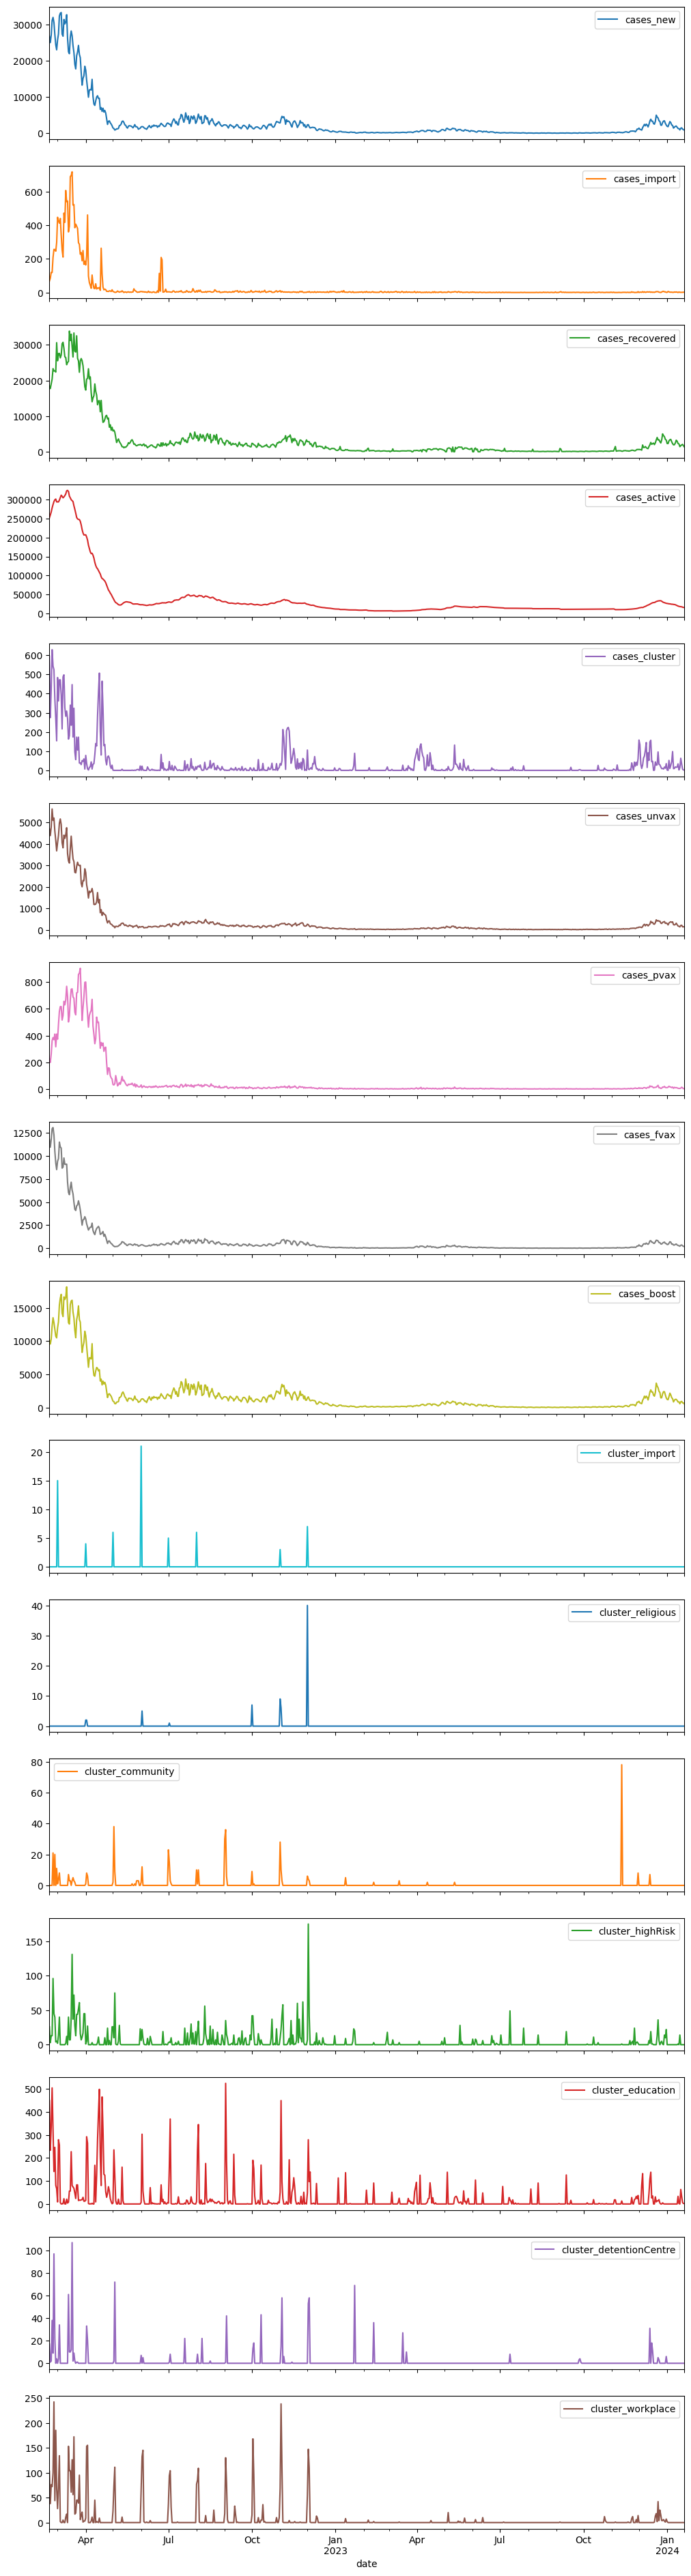

In [9]:
# Data Visualisation
plt.rcParams['figure.figsize'] = (12, 3 * 9)

plot_cols = ['cases_new', 'cases_import', 'cases_recovered', 'cases_active',
       'cases_cluster', 'cases_unvax', 'cases_pvax', 'cases_fvax',
       'cases_boost', 'cluster_import','cluster_religious', 'cluster_community', 'cluster_highRisk',
       'cluster_education', 'cluster_detentionCentre', 'cluster_workplace']

plt.rcParams['figure.figsize'] = (12, 3 * len(plot_cols))

plot_features = df_cases_train_malaysia[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [10]:
#Data Splitting (70%, 20%, 10%) split for the training, validation, and test sets
column_indices = {name: i for i, name in enumerate(df_cases_train_malaysia.columns)}

n = len(df_cases_train_malaysia)
train_df = df_cases_train_malaysia[0:int(n*0.7)]
val_df = df_cases_train_malaysia[int(n*0.7):int(n*0.9)]
test_df = df_cases_train_malaysia[int(n*0.9):]

num_features = df_cases_train_malaysia.shape[1]

cl = train_df.columns

In [11]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases_new,489.0,3925.415133,6883.310133,101.0,598.0,1709.0,3037.0,33406.0
cases_import,489.0,36.699387,110.127858,0.0,1.0,3.0,6.0,719.0
cases_recovered,489.0,4379.413088,7366.938943,0.0,643.0,1800.0,3290.0,33872.0
cases_active,489.0,48679.460123,74895.504591,6464.0,12436.0,24338.0,35534.0,323791.0
cases_cluster,489.0,42.376278,100.901823,0.0,0.0,4.0,27.0,629.0
cases_unvax,489.0,504.554192,1062.464619,10.0,68.0,160.0,278.0,5628.0
cases_pvax,489.0,80.411043,187.247209,0.0,3.0,9.0,24.0,904.0
cases_fvax,489.0,993.464213,2213.537313,16.0,106.0,334.0,634.0,13060.0
cases_boost,489.0,2346.985685,3591.164771,70.0,402.0,1205.0,2106.0,18170.0
cases_child,489.0,423.760736,898.859410,5.0,31.0,115.0,225.0,4389.0


In [12]:
#Data Normalizing Standardscaler
train_mean = train_df.mean()
train_std = train_df.std()

train_dfnn = (train_df - train_mean) / train_std
val_dfnn = (val_df - train_mean) / train_std
test_dfnn = (test_df - train_mean) / train_std


In [13]:
train_dfnn.fillna(0, inplace=True)

In [14]:
train_dfnn.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases_new,489.0,-2.906105e-17,1.0,-0.555607,-0.483403,-0.321998,-0.129068,4.282908
cases_import,489.0,-5.812211e-17,1.0,-0.333243,-0.324163,-0.306002,-0.278761,6.195532
cases_recovered,489.0,2.906105e-17,1.0,-0.594468,-0.507187,-0.350134,-0.147879,4.003371
cases_active,489.0,5.812211e-17,1.0,-0.563658,-0.483920,-0.325006,-0.175517,3.673272
cases_cluster,489.0,1.453053e-17,1.0,-0.419975,-0.419975,-0.380333,-0.152389,5.813807
cases_unvax,489.0,-2.906105e-17,1.0,-0.465478,-0.410888,-0.324297,-0.213235,4.822227
cases_pvax,489.0,0.000000e+00,1.0,-0.429438,-0.413416,-0.381373,-0.301265,4.398404
cases_fvax,489.0,0.000000e+00,1.0,-0.441585,-0.400926,-0.297923,-0.162394,5.451246
cases_boost,489.0,-2.906105e-17,1.0,-0.634052,-0.541603,-0.317999,-0.067105,4.406095
cases_child,489.0,-2.906105e-17,1.0,-0.465880,-0.436955,-0.343503,-0.221125,4.411412


In [15]:
# Single step
wide_window = WindowGenerator(input_width=30,label_width=30,shift=1,train_df=train_dfnn, val_df=val_dfnn, test_df=test_dfnn,label_columns=['cases_new'])
wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['cases_new']

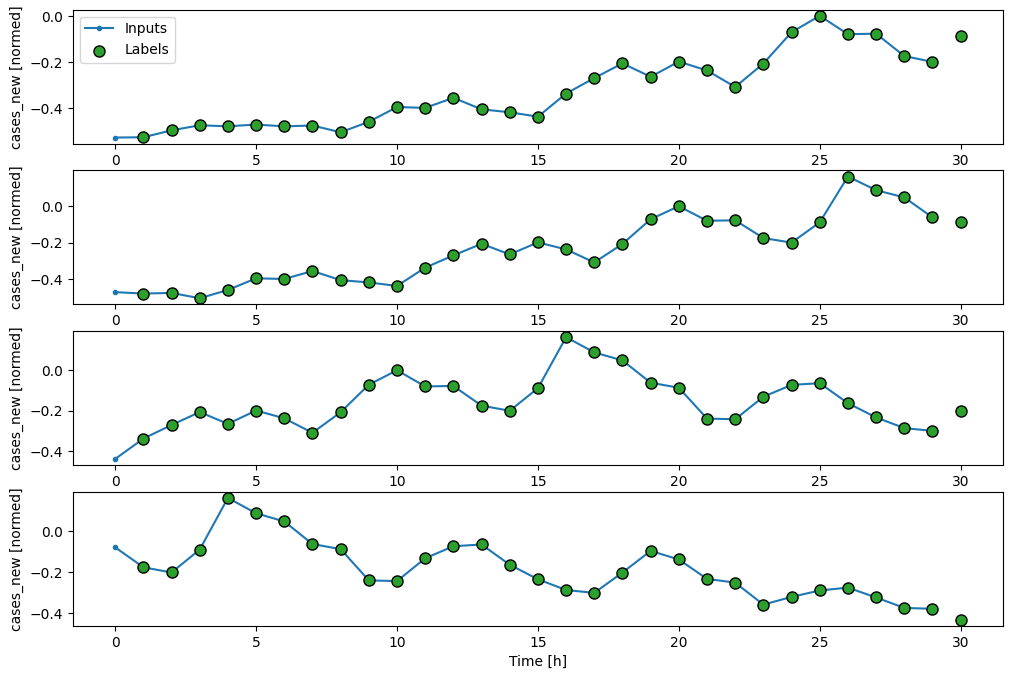

In [16]:
wide_window.plot(plot_col='cases_new',max_subplots=4)

In [17]:
# Filepath for checkpoint and tensorboard
filepath = os.getcwd()

print(filepath)

c:\Users\USER\Downloads\AI_SHRDC\Capstone1


In [18]:
# Checkpoint Path
checkpoint_filepath = r"c:\Users\USER\Downloads\AI_SHRDC\Capstone1\chechpoint.h5"

In [19]:
# Tensorboard Path
logpath = os.path.join(filepath,'tensorboard_log',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = callbacks.TensorBoard(logpath)

In [20]:
# Implement Regularizer
regularization_strength = 0.01

In [21]:
# Create LSTM single 
lstm_single_step = tf.keras.models.Sequential()

lstm_single_step.add(tf.keras.layers.LSTM(32, return_sequences=True))

lstm_single_step.add(tf.keras.layers.Dense(1))

In [22]:
from windowing import compile_and_fit

In [23]:
# Model Training
history_single_step = compile_and_fit(lstm_single_step,wide_window,checkpoint_filepath,tb)

Epoch 1/30
 9/15 [=================>............] - ETA: 0s - loss: 0.3125 - mean_absolute_percentage_error: 412.2639 
Epoch 1: saving model to c:\Users\USER\Downloads\AI_SHRDC\Capstone1\chechpoint.h5
15/15 [==============================] - 4s 38ms/step - loss: 0.2600 - mean_absolute_percentage_error: 459.4627 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 15.9333
Epoch 2/30
 9/15 [=================>............] - ETA: 0s - loss: 0.0960 - mean_absolute_percentage_error: 402.4060
Epoch 2: saving model to c:\Users\USER\Downloads\AI_SHRDC\Capstone1\chechpoint.h5
15/15 [==============================] - 0s 12ms/step - loss: 0.0898 - mean_absolute_percentage_error: 362.4413 - val_loss: 0.0288 - val_mean_absolute_percentage_error: 27.1419
Epoch 3/30
 9/15 [=================>............] - ETA: 0s - loss: 0.0424 - mean_absolute_percentage_error: 249.1112
Epoch 3: saving model to c:\Users\USER\Downloads\AI_SHRDC\Capstone1\chechpoint.h5
15/15 [==============================] - 0s 1

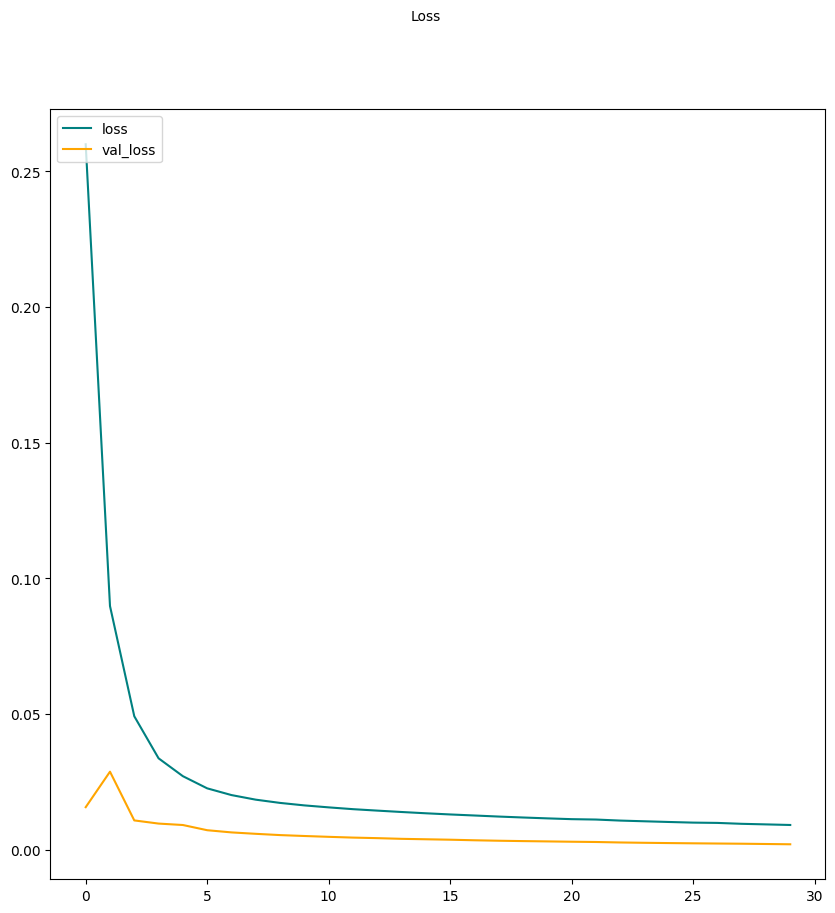

In [24]:
# Graph Between Loss and Val Loss
fig = plt.figure(figsize=(10,10))
plt.plot(history_single_step.history['loss'],color='teal',label='loss')
plt.plot(history_single_step.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=10)
plt.legend(loc='upper left')
plt.show()

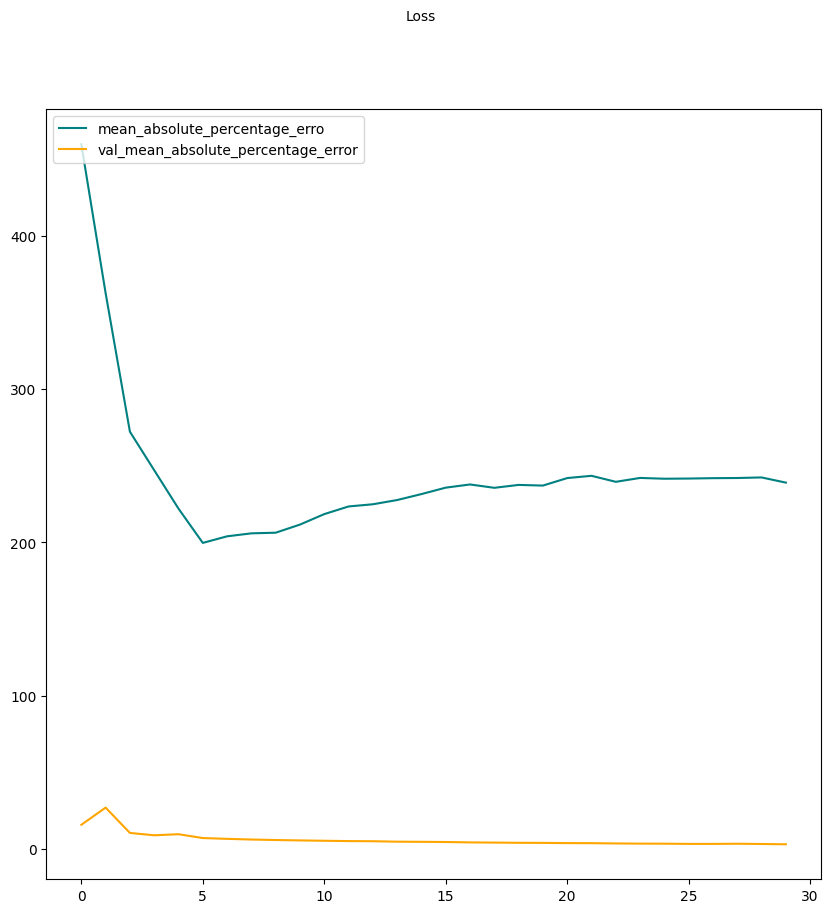

In [25]:
# Graph Absolute Percentage
fig = plt.figure(figsize=(10,10))
plt.plot(history_single_step.history['mean_absolute_percentage_error'],color='teal',label='mean_absolute_percentage_erro')
plt.plot(history_single_step.history['val_mean_absolute_percentage_error'],color='orange',label='val_mean_absolute_percentage_error')
fig.suptitle('Loss',fontsize=10)
plt.legend(loc='upper left')
plt.show()

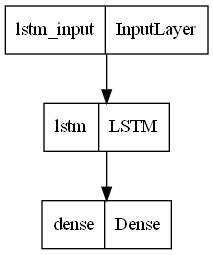

In [26]:
keras.utils.plot_model(lstm_single_step)

In [27]:
lstm_single_step.load_weights(checkpoint_filepath)

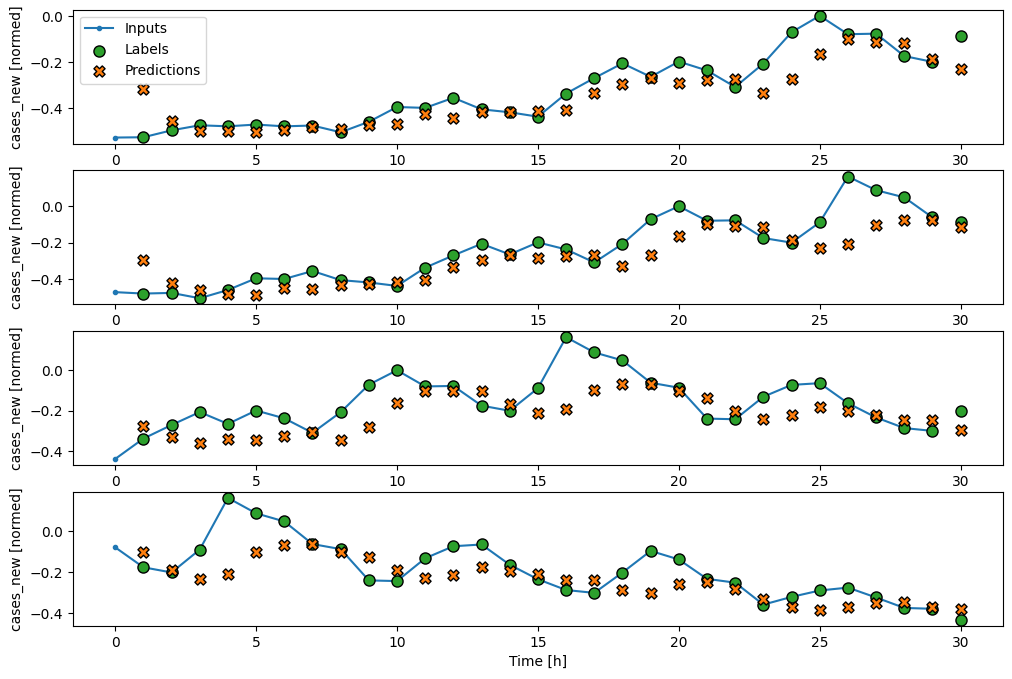

In [28]:
# Plot the result 
wide_window.plot(plot_col='cases_new',model=lstm_single_step,max_subplots=4)